<a href="https://colab.research.google.com/github/SaharaAli16/spatiotemporal-causality/blob/main/stcausal2024/hands-on-demo/Causal_Inference_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Causal Effect Estimation using Time-Series Data

In this notebook, we will see how can we estimate the causal effect from time-series data.

Here are the steps that will be involved in this notebook.
1. Load necessary libraries
2. Specify the problem and the causal graph
3. Generate data set
4. Causal effect estimation and analysis

We will look at following two time-series scenarios and methods applicable to each one of them:
1. Time-invariant causal inference
2. Time-varying causal inference

# 1. Time-invariant Causal Inference


## Causal Impact
Source: https://pypi.org/project/pycausalimpact/

We are first going to look at an example of time-invariant causal inference using Causal Impact.
The Causal Impact (Brodersen et al. 2015) method was developed by Google’s Research and Data Science teams. It builds a Bayesian structural time series (BSTS) model to represent the expected behavior of the time series data in the presence and absence of the intervention. The difference between the observed post-intervention data and the counterfactual prediction represents the causal impact of the intervention.
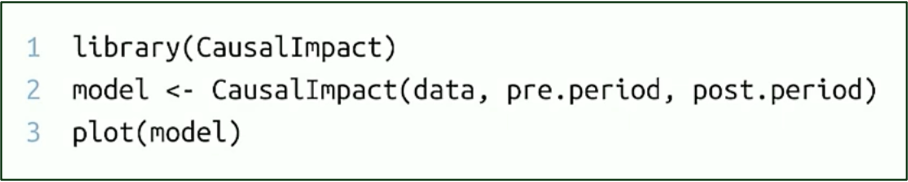

## 1.1 Initial Setup

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess


!pip install pycausalimpact
from causalimpact import CausalImpact

## 1.2 Synthetic Data Generation

In [2]:
np.random.seed(12345)
ar = np.r_[1, 0.9]
ma = np.array([1])
arima_process = ArmaProcess(ar, ma)
X = 100 + arima_process.generate_sample(nsample=100)
y = 1.2 * X + np.random.normal(size=100)
y[70:] += 5

data = pd.DataFrame({'y': y, 'X': X}, columns=['y', 'X'])

## 1.3 Causal Effect Estimation

In [3]:
#Specify Pre-intervention Time
pre_period = [0, 69]
#Specify Post-intervention Time
post_period = [70, 99]


ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))

/usr/local/lib/python3.10/dist-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/usr/local/lib/python3.10/dist-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packa

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    125.23             3756.86
Prediction (s.d.)         120.39 (0.28)      3611.81 (8.37)
95% CI                    [119.83, 120.93]   [3595.02, 3627.83]

Absolute effect (s.d.)    4.84 (0.28)        145.06 (8.37)
95% CI                    [4.3, 5.39]        [129.03, 161.85]

Relative effect (s.d.)    4.02% (0.23%)      4.02% (0.23%)
95% CI                    [3.57%, 4.48%]     [3.57%, 4.48%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 125.23. By contrast, in the absence of an
intervention, we would have expected an average response of 120.39.
The 95% interval of this counterfactual prediction is [119.83, 120.93].
Subtracting this prediction from 

# 2. Time-varying Causal Inference


## 2.1 Initial Setup

In [13]:
import numpy as np
from math import sqrt
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Dropout
from tensorflow.keras.layers import Concatenate, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras import regularizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy

## 2.2 Synthetic Dataset Generation

We are going to generate four time-series following the causal structure below:
1. S1: Auto-correlated time-series
2. S2: Non-linear time-series causally derived from S1 (S1 > S2)
3. S3: Non-linear time-series causally derived from S1 (S1 > S3)
4. S4: Non-linear and auto-correlated time-series causally derived from S1 and S3 (S1, S3 > S4)
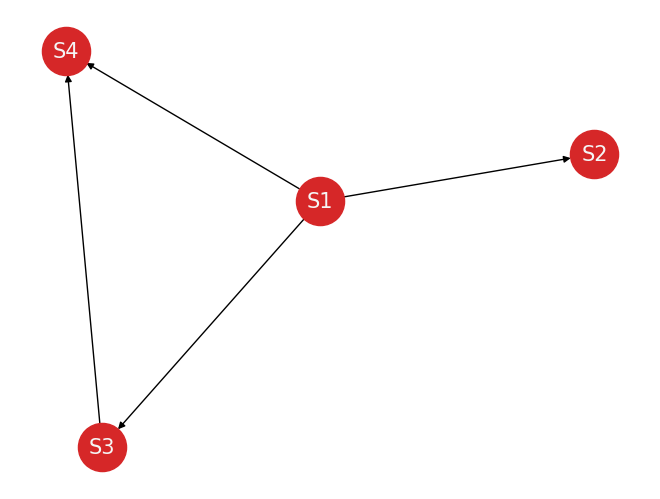

In [5]:
## Generating Counterfactual data

#Size of time-series: t
t = 10000

#Create noise
np.set_printoptions(suppress=True)
noise = np.random.normal(0,1,t)
print(noise.size)

#Variable S1
source1 = np.zeros((t))
for i in range(0,t):
  if(i<10):
    source1[i] = np.cos(i/10) + noise[i]*0.1
  else:
    source1[i] = np.cos(i/10) + np.log(np.abs(source1[i-6] - source1[i-10]) + 1) + noise[i]*0.1


#Variable S2
source2 = np.zeros((t))
np.set_printoptions(suppress=True)
noise2 = np.random.normal(0,1,t)
source2[1] = noise2[1]
source2[2] = noise2[2]
for x in range(3,t):
  if source1[x-1] > 0:
     source2[x] = 1.2*math.exp(-source1[x-1]*source1[x-1]/2) + noise2[x]
  else:
     source2[x] = -2*math.exp(-source1[x-1]*source1[x-1]) + noise2[x]

#Variable S3
source3 = np.zeros((t))
np.set_printoptions(suppress=True)
noise3 = np.random.normal(0,1,t)
source3[1] = noise3[1]
source3[2] = noise3[2]
for x in range(3,t):
  source3[x] = -1.05*math.exp(-source1[x-1]*source1[x-1]/2) + noise3[x]

#Variable S4
source4 = np.zeros((t))
source4_cf0 = np.zeros((t))
source4_cf1 = np.zeros((t))
treat = np.zeros((t))
np.set_printoptions(suppress=True)
noise4 = np.random.normal(0,1,t)
source4[1] = noise4[1] + 10
source4[2] = noise4[2] + 10

#Factual Data Generation
for x in range(3,t):
  source4[x] = -1.15*math.exp(-source1[x-1]*source1[x-1]/2) + 0.2*math.sqrt(2)*math.exp(-source4[x-1]*source4[x-1]/2) + 1.35*math.exp(-source3[x-1]*source3[x-1]/2) + noise4[x]

#Counterfactual Data Generation
source4_cf0[1] = noise4[1] + 10
source4_cf0[2] = noise4[2] + 10
source4_cf1[1] = noise4[1] + 10
source4_cf1[2] = noise4[2] + 10
for x in range(3,t):
  #Binary Treatment: 1
  source4_cf1[x] = -1.15*math.exp(-source1[x-1]*source1[x-1]/2) + 0.2*math.sqrt(2)*math.exp(-source4[x-1]*source4[x-1]/2) + 1.35*math.exp(-1*1/2) + noise4[x]
  #Binary Treatment: 0
  source4_cf0[x] = -1.15*math.exp(-source1[x-1]*source1[x-1]/2) + 0.2*math.sqrt(2)*math.exp(-source4[x-1]*source4[x-1]/2) + 1.35*math.exp(0) + noise4[x]

data = np.zeros((t,4))
data[:,0] = source1
data[:,1] = source2
data[:,2] = source3
data[:,3] = source4

cf_data = np.zeros((t,2))
cf_data[:,0] = source4_cf1
cf_data[:,1] = source4_cf0


10000


## 2.3 Define Helper Functions

In [7]:
from os import uname
#Generating training, testing and treatment datasets

def train_test_treat_generator(data, lag):
  train_x = data[:-lag]
  train_y = data[lag:, -1]
  test_x = data[:-lag]
  test_y = data[lag:, -1]

#create treated and untreated versions
  treated = np.copy(train_x)
  treated[:,2] = 1 #Replacing S3 with ones
  untreated = np.copy(train_x)
  untreated[:,2] = 0 #Replacing S3 with zeros

  print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
  print(treated.shape, untreated.shape)

  return train_x, train_y, test_x, test_y, treated, untreated

In [8]:
train_x, train_y, test_x, test_y, treated, untreated = train_test_treat_generator(data, 1)

(9999, 4) (9999,) (9999, 4) (9999,)
(9999, 4) (9999, 4)


In [17]:
def data_normalizer(train_x, train_y, test_x, test_y, treated, untreated):
  scaler_x = StandardScaler()
  train_x = scaler_x.fit_transform(train_x.reshape(-1,train_x.shape[1])) #reshaping to 2d for standard scaling
  test_x = scaler_x.transform(test_x.reshape(-1,test_x.shape[1])) #reshaping to 2d for standard scaling
  treated = scaler_x.transform(treated.reshape(-1,treated.shape[1])) #reshaping to 2d for standard scaling
  untreated = scaler_x.transform(untreated.reshape(-1,untreated.shape[1])) #reshaping to 2d for standard scaling

  scaler_y = StandardScaler()
  train_y = scaler_y.fit_transform(train_y.reshape(-1,1)) #reshaping to 2d for standard scaling
  test_y = scaler_y.transform(test_y.reshape(-1,1)) #reshaping to 2d for standard scaling
  return scaler_x, scaler_y, train_x, train_y, test_x, test_y, treated, untreated

In [18]:
scaler_x, scaler_y, train_x, train_y, test_x, test_y, treated, untreated = data_normalizer(train_x, train_y, test_x, test_y, treated, untreated)

In [19]:
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

In [20]:
timesteps = 1
train_x = reshape_features(train_x, timesteps) # reshaping to 3d for model
test_x = reshape_features(test_x, timesteps) # reshaping to 3d for model

treated = reshape_features(treated, timesteps) # reshaping to 3d for model
untreated = reshape_features(untreated, timesteps) # reshaping to 3d for model

(9999, 4)
(9999, 4)
(9999, 4)
(9999, 4)


In [21]:
# We will use the MSE loss function as base loss
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

## 2.4 Propensity Score Calculation

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#Propensity Score Calculation i.e Probability of Treatment given covariates = P(T|X)
def iptw(x_train, n_features):
  tr = x_train.reshape(-1,n_features)[:,-2]
  cov = x_train.reshape(-1,n_features)[:,:-2]
  y = np.zeros_like(tr)
  for i in range(len(tr)):
    if tr[i] > tr.mean():
      y[i] = 1
  print(tr.shape)
  print(cov.shape)
  print(y.shape)
  model = LogisticRegression().fit(cov, y)
  prop_score = model.predict_proba(cov) #probabilities of belonging to a class

  iptw = 1 / prop_score
  print(prop_score.shape)
  print(iptw.shape)
  print(iptw[0,1])

  return iptw
#prop_score has two columns. prop_score[:,1] has probability of treatment being 1, i.e treat > treat.mean().
#Likewise, prop_score[:,0] has probability of treatment being 0, i.e treat < treat.mean()
#We use these probabilities to calculate IPTW

In [28]:
iptw_weights = iptw(train_x, 4)
iptw_weights = iptw_weights.reshape(-1, 1)  # Reshape to (num_samples, 1)
iptw_weights = np.tile(iptw_weights, (1, train_y.shape[1]))


(9999,)
(9999, 2)
(9999,)
(9999, 2)
(9999, 2)
1.7963277300751899


## 2.5 Building the Model

In [23]:
def model(timestep, features, reg_l2):

    x = Input(shape=(timestep,features), name='input')

    # representation
    phi = LSTM(64, return_sequences=True,name='phi_1')(x)
    phi = Dropout(0.2)(phi)
    phi = LSTM(32, return_sequences=True,name='phi_2')(phi)
    #phi = Attention(32)(phi)
    phi = LSTM(32, return_sequences=False,name='phi_3')(phi)
    phi = Dense(units=25, activation='elu', kernel_initializer='RandomNormal',name='phi_4')(phi)
    phi = Dropout(0.2)(phi)

    y0_hidden = Dense(units=25, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y0_hidden = Dense(units=25, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    model = Model(inputs=x, outputs=y0_predictions)

    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ phi_1 (LSTM)                         │ (None, 1, 64)               │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ phi_2 (LSTM)                         │ (None, 1, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ phi_3 (LSTM)                         │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ phi_4 (Dense)                        │ (None, 25)                  │             825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ y0_hidden_1 (Dense)                  │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ y0_hidden_2 (Dense)                  │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ y0_predictions (Dense)               │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,551 (158.40 KB)

 Trainable params: 40,551 (158.40 KB)

 Non-trainable params: 0 (0.00 B)

None


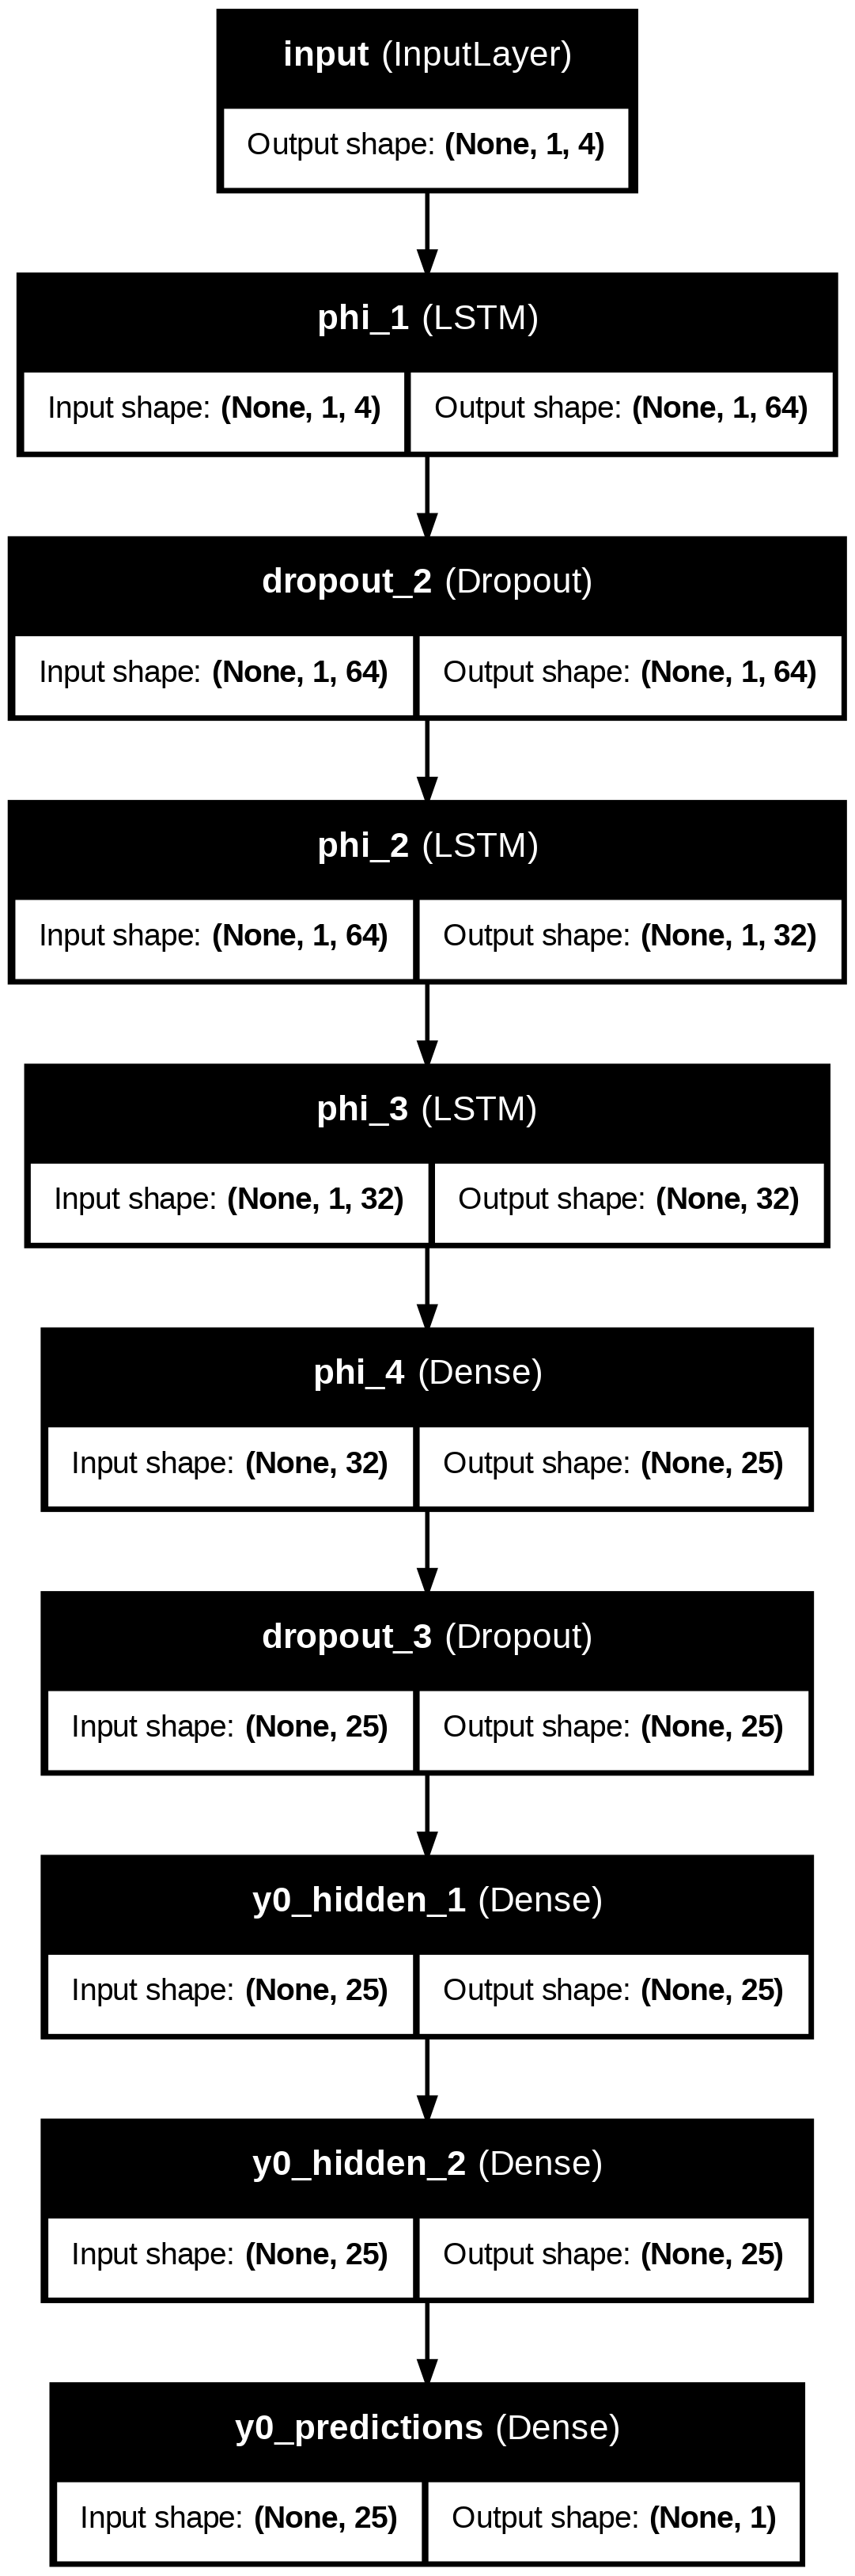

In [24]:
model=model(1,4, .01)

print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='slearner.png')

from IPython.display import Image # this just Jupyter notebook stuff
Image(retina=True, filename='slearner.png')

In [29]:
val_split=0.2
batch_size=32
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

#Compiling the network
model.compile(loss=loss_fn, optimizer='adam', metrics=['mse'])
#
checkpoint_path='./testmodel.keras'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

model.fit(x=train_x,y=train_y,
                validation_split=0.2,
                epochs=100,
                batch_size=batch_size,
                shuffle=False,
                sample_weight=iptw_weights,
                callbacks=keras_callbacks,
                verbose=verbose)



Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 2.4633 - mse: 1.0437 - val_loss: 1.7811 - val_mse: 0.8206
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 1.9828 - mse: 0.9303 - val_loss: 1.6730 - val_mse: 0.8007
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.8894 - mse: 0.9095 - val_loss: 1.6171 - val_mse: 0.7831
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.8392 - mse: 0.8931 - val_loss: 1.5928 - val_mse: 0.7754
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.8400 - mse: 0.8976 - val_loss: 1.5884 - val_mse: 0.7756
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8262 - mse: 0.8934 - val_loss: 1.5784 - val_mse: 0.7720
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.8170 - mse: 0.8898 - val_loss: 1.5744 - val_mse: 0.7710
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8164 - mse: 0.8909 - val_loss: 1.5711 - val_mse: 0.7700
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2

## 2.6 Causal Effect Estimation

In [30]:
import pandas as pd
import numpy as np

y0_pred=model.predict(untreated)
y1_pred=model.predict(treated)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [31]:
y1_pred = scaler_y.inverse_transform(y1_pred)
y0_pred = scaler_y.inverse_transform(y0_pred)

In [32]:
cate_pred=(y1_pred-y0_pred).squeeze()
cate_true=(cf_data[1:,0]-cf_data[1:,1]).squeeze()

ate_pred=tf.reduce_mean(cate_pred)
ate_true=tf.reduce_mean(cate_true)

print("True ATE:",ate_true.numpy())
print("Estimated ATE:",ate_pred.numpy())

True ATE: -0.5310773620413315
Estimated ATE: -0.60800177
